In [357]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import json

import Feature_Extraction as fe

In [2]:
# load the dataset

data = open('data/tousend_cons_rels.CSV', encoding="ANSI").read()
label, r1, r2, rmix = [], [], [], []
size = 500
for i, line in enumerate(data.split("\n")):
    if i >= size:
        break
    if line != '' and line.isspace() != True:
        content = line.split(';')
        label.append(content[0])
        r1.append(content[1])
        r2.append(content[2])
        rmix.append(content[1]+content[2])
        
index = 0
size = len(label)
x = []
while index < size:
    x.append(fe.createFBag(r1[index], r2[index]))
    index = index + 1
    
vec = DictVectorizer()

xx = vec.fit_transform(x).toarray()

yy = []
for l in label:
    if l == 'true':
        yy.append(1)
    else:
        yy.append(-1)

In [204]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [287]:
def doHyperParameterTuning(X, y, clfs_params):
    kfold = 10
    inner_skf = StratifiedKFold(n_splits=kfold)
    outer_skf = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=5, random_state=1)

    
    data = {'precision': {}, 'recall' : {}, 'f1' : {},
            'tp' : {}, 'fp' : {}, 'tn' : {}, 'fn' : {}}
        
    models = []
    #for parameter tuning we only take f1 into consideration
    scores = ["f1"]
    for score in scores:
        for clf in clfs_params.keys():
            print()
            print("************************************************************")
            print("Model:", clf)
            print()
            if clfs_params[clf] != []:
                gscv = GridSearchCV(estimator=clf, param_grid=clfs_params[clf], cv=inner_skf, scoring = score, n_jobs=-1)
                gscv.fit(X, y)
                print(gscv.best_params_)
                means = gscv.cv_results_['mean_test_score']
                stds = gscv.cv_results_['std_test_score']
                for mean, std, params in zip(means, stds, gscv.cv_results_['params']):
                    print("%0.2f (+/-%0.02f) for %r" % (mean, std * 2, params))
                the_clf = gscv.best_estimator_
            else:
                the_clf = clf
            models.append(the_clf)
            scoring =  {'precision':'precision', 'recall':'recall', 'f1':'f1', 'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}   
            res = cross_validate(the_clf, X=X, y=y, cv=outer_skf, scoring=scoring, n_jobs=-1)
            for scr in scoring.keys():
                data[scr][type(clf).__name__] = res['test_' + scr].tolist()
    return data, models

In [289]:
import warnings
warnings.filterwarnings('ignore')

modelparams = {SVC():[{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced']}],
               SGDClassifier(): [{'loss': ['hinge', 'log', 'modified_huber'], 'alpha': [0.0001, 0.05]}],
               LogisticRegression():[{'solver':['liblinear'], 'penalty': ['l1', 'l2'], 'C':np.logspace(-4, 4, 20), 'class_weight':['balanced', None]},
                       {'solver':['lbfgs', 'sag', 'newton-cg'], 'penalty': ['l2'], 'C':np.logspace(-4, 4, 20), 'class_weight':['balanced', None]}],
               NearestCentroid(): [],
               KNeighborsClassifier(): [],
               LinearDiscriminantAnalysis(): [{'solver': ['svd', 'lsqr']}],
               GaussianNB(): [],
               ComplementNB(): [],
               RandomForestClassifier():[{'n_estimators': [10, 100, 500, 1000], 'max_depth': [None, 5, 15, 30], 'min_samples_split': [2, 5, 50], 'min_samples_leaf': [1, 5, 10] }],
               ExtraTreesClassifier():[{'n_estimators': [10, 100, 500, 1000], 'max_depth': [None, 5, 15, 30], 'min_samples_split': [2, 5, 50], 'min_samples_leaf': [1, 5, 10] }],
               MLPClassifier():[{'hidden_layer_sizes': [(5, 2), (50, 2), (50, 5), (100, 2), (100, 10)],'activation': ['tanh', 'relu'],'solver': ['lbfgs','sgd', 'adam'],
                                 'alpha': [0.0001, 0.05],'learning_rate': ['constant','adaptive', 'invscaling']}]
              }

mydata, final_models = doHyperParameterTuning(xx, yy, modelparams)

json = json.dumps(mydata)
f = open("results.json","w")
f.write(json)
f.close()


************************************************************
Model: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.00 (+/-0.00) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.00 (+/-0.00) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.00 (+/-0.00) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.00 (+/-0.00) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.53 (+/-0.58) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.00 (+/-0.00) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.68 (+/-0.50) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.53 (+/-0.58) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.67 (+/-0.60) for {'C': 1, 'class_weight': None, 'kernel': 'linear'}
0.59 (+/-0.30) for {'C': 1, 'class_weight': 'balanced', 'kernel': 'li

0.63 (+/-0.48) for {'C': 0.08858667904100823, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
0.00 (+/-0.00) for {'C': 0.08858667904100823, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.00 (+/-0.00) for {'C': 0.08858667904100823, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}
0.00 (+/-0.00) for {'C': 0.08858667904100823, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
0.65 (+/-0.40) for {'C': 0.23357214690901212, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
0.65 (+/-0.40) for {'C': 0.23357214690901212, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}
0.65 (+/-0.40) for {'C': 0.23357214690901212, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
0.16 (+/-0.46) for {'C': 0.23357214690901212, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.16 (+/-0.46) for {'C': 0.23357214690901212, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}
0.16 (+/-0.46) for {'C': 0.2335721

                     weights='uniform')


************************************************************
Model: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

{'solver': 'svd'}
0.67 (+/-0.60) for {'solver': 'svd'}
0.18 (+/-0.05) for {'solver': 'lsqr'}

************************************************************
Model: GaussianNB(priors=None, var_smoothing=1e-09)


************************************************************
Model: ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)


************************************************************
Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       m

0.00 (+/-0.00) for {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 500}
0.00 (+/-0.00) for {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 1000}

************************************************************
Model: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.61 (+/-0.42) for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.63 (+/-0.34) for {'max_depth': None, 'm

              validation_fraction=0.1, verbose=False, warm_start=False)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 5), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.65 (+/-0.38) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.00 (+/-0.00) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'constant', 'solver': 'sgd'}
0.51 (+/-0.62) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'constant', 'solver': 'adam'}
0.60 (+/-0.43) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.00 (+/-0.00) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.53 (+/-0.65) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'adaptive', 'solver'

0.39 (+/-0.68) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.00 (+/-0.00) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'constant', 'solver': 'sgd'}
0.33 (+/-0.72) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'constant', 'solver': 'adam'}
0.46 (+/-0.75) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.00 (+/-0.00) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.48 (+/-0.62) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.51 (+/-0.52) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.06 (+/-0.18) for {'activation

AttributeError: 'str' object has no attribute 'dumps'

In [295]:
import json
json = json.dumps(mydata)
f = open("results.json","w")
f.write(json)
f.close()

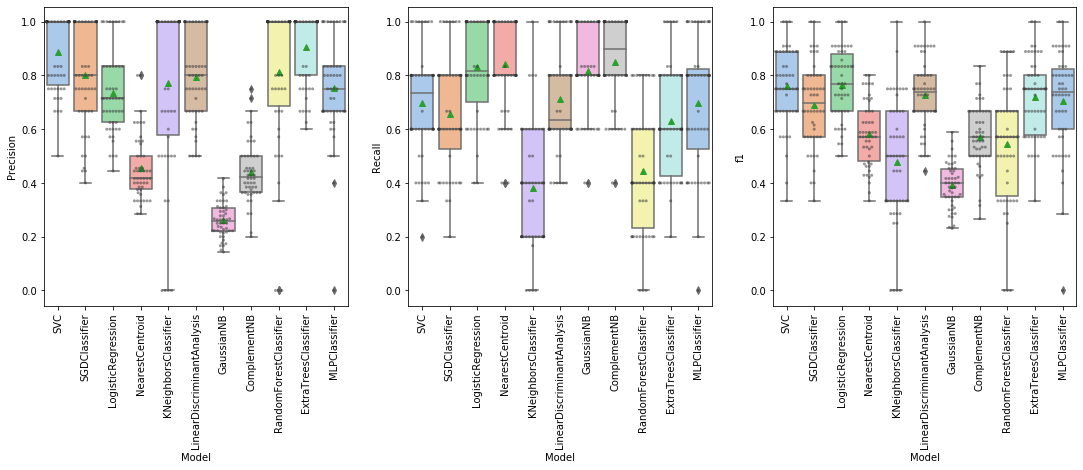

In [462]:
precision_df = pd.DataFrame(mydata['precision'])
recall_df = pd.DataFrame(mydata['recall'])
f1_df = pd.DataFrame(mydata['f1'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

axp = sns.boxplot(data=precision_df, showmeans=True, palette="pastel", ax=ax1)
#axp = sns.swarmplot(data=precision_df, size=3, orient="v", color='.2', alpha=0.5, ax=ax1)
axp.set(xlabel='Model', ylabel='Precision')
axp.set_xticklabels(axp.get_xticklabels(),rotation=90)

axr = sns.boxplot(data=recall_df, showmeans=True, palette="pastel", ax=ax2)
#axp = sns.swarmplot(data=recall_df, size=3, orient="v", color='.2', alpha=0.5, ax=ax2)
axr.set(xlabel='Model', ylabel='Recall')
axr.set_xticklabels(axp.get_xticklabels(),rotation=90)

axr = sns.boxplot(data=f1_df, showmeans=True, palette="pastel", ax=ax3)
#axp = sns.swarmplot(data=f1_df, size=3, orient="v", color='.2', alpha=0.5, ax=ax3)
axr.set(xlabel='Model', ylabel='f1')
axr.set_xticklabels(axp.get_xticklabels(),rotation=90)

plt.savefig('modelcomparison_1.pdf', bbox_inches = "tight")


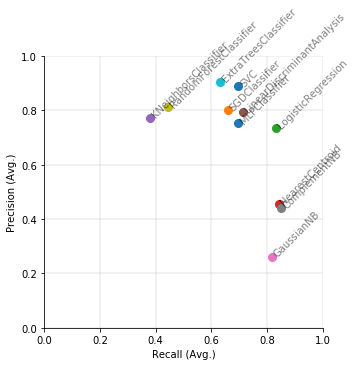

In [470]:
tmp_dic = {}
for m in precision_df:
    tmp_dic[m] = [np.mean(precision_df[m]), np.mean(recall_df[m])]
tmp_df = pd.DataFrame(tmp_dic, index=['Precision', 'Recall'])
tmp_df = tmp_df.T

fig, ax = plt.subplots(figsize=(5, 5))
for index, row in tmp_df.iterrows():
    ax .plot(row['Recall'], row['Precision'], marker='o', linestyle='', ms=8, label=index)
for i in tmp_df.index.values:
    ax.annotate(i, (tmp_df.loc[i]['Recall'], tmp_df.loc[i]['Precision']), alpha=0.5, rotation=45)
ax.set_ylim(ymin=0, ymax=1)
ax.set_xlim(xmin=0, xmax=1) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.8)
ax.set_xlabel('Recall (Avg.)')
ax.set_ylabel('Precision (Avg.)')

plt.savefig('modelcomparison_2.pdf', bbox_inches = "tight")

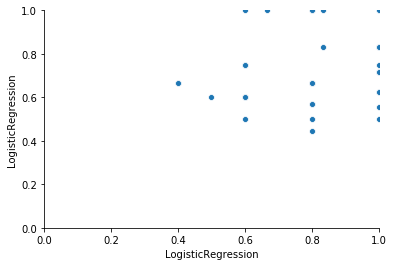

In [460]:
p = sns.scatterplot(recall_df['LogisticRegression'], precision_df['LogisticRegression'])
p.set_xlim(0,1)
p.set_ylim(0,1)
p.spines['top'].set_visible(False)
p.spines['right'].set_visible(False)


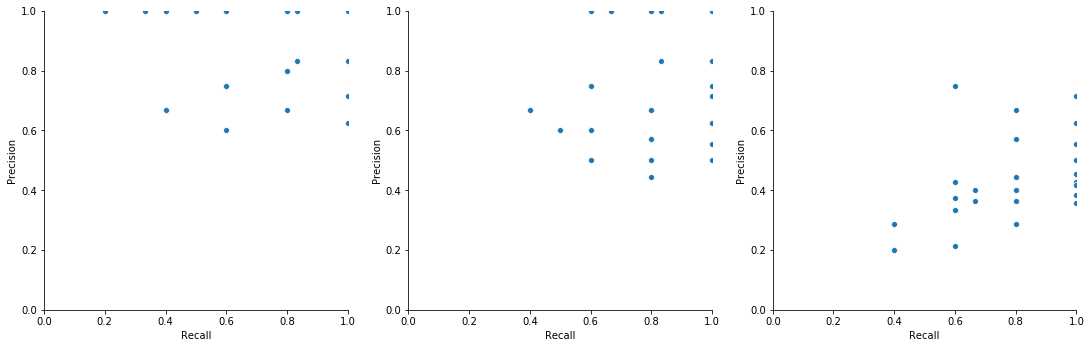

In [531]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

#p1 = sns.kdeplot(recall_df['ExtraTreesClassifier'], precision_df['ExtraTreesClassifier'], n_levels=50, ax=ax1)
p1 = sns.scatterplot(recall_df['ExtraTreesClassifier'], precision_df['ExtraTreesClassifier'],  ax=ax1)
p1.set_xlabel('Recall')
p1.set_ylabel('Precision')
p1.set_xlim(0,1)
p1.set_ylim(0,1)
p1.spines['top'].set_visible(False)
p1.spines['right'].set_visible(False)


#p2 = sns.kdeplot(recall_df['LogisticRegression'], precision_df['LogisticRegression'], n_levels=50, ax=ax2)
p2 = sns.scatterplot(recall_df['LogisticRegression'], precision_df['LogisticRegression'], ax=ax2)
p2.set_xlabel('Recall')
p2.set_ylabel('Precision')
p2.set_xlim(0,1)
p2.set_ylim(0,1)
p2.spines['top'].set_visible(False)
p2.spines['right'].set_visible(False)


p3 = sns.scatterplot(recall_df['ComplementNB'], precision_df['ComplementNB'],  ax=ax3)
p3.set_xlabel('Recall')
p3.set_ylabel('Precision')
p3.set_xlim(0,1)
p3.set_ylim(0,1)
p3.spines['top'].set_visible(False)
p3.spines['right'].set_visible(False)



In [490]:
tmp_dict = {}
for k1 in ['tp', 'fp', 'tn', 'fp']:
    for k2 in mydata[k1].keys():
        tmp_dict[k2 + '_' + k1] = mydata[k1][k2]
df = pd.DataFrame(tmp_dict)
df

,SVC_tp,SGDClassifier_tp,LogisticRegression_tp,NearestCentroid_tp,KNeighborsClassifier_tp,LinearDiscriminantAnalysis_tp,GaussianNB_tp,ComplementNB_tp,RandomForestClassifier_tp,ExtraTreesClassifier_tp,...,SGDClassifier_tn,LogisticRegression_tn,NearestCentroid_tn,KNeighborsClassifier_tn,LinearDiscriminantAnalysis_tn,GaussianNB_tn,ComplementNB_tn,RandomForestClassifier_tn,ExtraTreesClassifier_tn,MLPClassifier_tn
0,3,2,4,4,2,3,5,6,2,3,...,45,45,39,45,43,34,39,45,45,45
1,4,5,5,5,4,4,5,5,4,5,...,44,44,36,43,44,36,39,45,45,43
2,2,2,2,4,2,2,4,4,2,2,...,45,44,40,43,43,37,40,44,44,44
3,3,3,5,5,0,3,5,4,1,4,...,44,43,42,44,44,32,40,44,44,43
4,3,2,3,4,4,3,3,4,2,3,...,42,42,40,45,45,33,43,45,45,42
5,2,2,2,2,1,2,5,2,1,2,...,43,44,41,45,44,33,37,45,45,45
6,4,4,4,4,0,4,4,4,4,3,...,43,41,39,44,41,26,38,44,43,43
7,4,4,4,5,0,3,3,5,1,3,...,43,43,38,44,45,27,38,45,45,43
8,4,4,5,5,3,5,3,5,1,4,...,45,43,37,45,44,34,37,45,45,45
9,4,4,5,4,3,4,5,4,4,3,...,44,43,43,44,44,36,39,44,44,44
